In [1]:
import numpy as np

import sys
sys.path.insert(0, '../src/easyesn/')

In [2]:
from easyesn import PredictionESN, BaseESN
from easyesn import helper as hlp
from easyesn.optimizers import GradientOptimizer
import matplotlib.pyplot as plt
import easyesn

np.random.seed(42)

Using Numpy backend.


In [86]:
#generate train/test data


inputLength = 1000
trainingLength = int(inputLength*0.7)
data = np.linspace(0, 10*np.pi, inputLength).reshape(-1,1)

"""
inputData = np.sin(data)
outputData = np.cos(data)

"""
inputData = np.loadtxt("MackeyGlass_t17.dat").reshape((-1, 1))
outputData = inputData[84:]
inputData = inputData[:-84]


inputLength = len(inputData)
trainingLength = int(inputLength*0.7)

inputDataTraining = inputData[:trainingLength]
inputDataValidation = inputData[trainingLength:]

outputDataTraining = outputData[:trainingLength]
outputDataValidation = outputData[trainingLength:]

In [73]:
class EnsembleESN(object):
    def __init__(self, n_input, n_output, ensembleMembers, judgeESN):
        self.n_input = n_input
        self.n_output = n_output
        
        self._ensemble = []
        if type(ensembleMembers) is tuple:
            #first item of tuple is number of members
            #second item is the funtion to generate the member
            
            for i in range(ensembleMembers[0]):
                self._ensemble.append(ensembleMembers[1](i))
        else:
            for item in ensembleMembers:
                self._ensemble.append(item)
                
        #check the validity of the ensemble members
        for esn in self._ensemble:
            if not issubclass(type(esn), easyesn.BaseESN.BaseESN):
                raise ValueError("All objects inserted in/generated by ensembleMembers argument must be inherited from BaseESN")
            else:
                if esn.n_input != n_input or esn.n_output != n_output:
                    raise ValueError("At least one member of the ensemble has different input/output dimensions as the entire ensemble is ought to have")
             
        self._judgeESN = judgeESN
        if judgeESN.n_input != n_input + len(self._ensemble) or esn.n_output != n_output:
                raise ValueError("The judge ESN has to have n_input = {0} and n_output = {1} for this ensemble".format(n_input + len(self._ensemble), n_output))
            
   
    def fit(self, inputData, outputData, transientTime="AutoReduce", transientTimeCalculationEpsilon = 1e-3, transientTimeCalculationLength = 20, verbose=0):
        trainErrors = []
        trainPredictions = []
        
        #TODO: get value for transientTimeValue
        transientTimeValue = 100
        
        #reshape the input/output data to have the shape (timeseries, time, dimension)
        if len(outputData.shape) <= 2:
            outputData = outputData.reshape((1, -1, self.n_output))
        if len(inputData.shape) <= 2:
            inputData = inputData.reshape((1, -1, self.n_input))

        if inputData is not None:
            inputData = np.array(inputData)
        if outputData is not None:
            outputData = np.array(outputData)
        
        #only use the FIRST timeseries submitted
        inputData = inputData[0]
        outputData = outputData[0]
        
        #train ensemble
        for esn in self._ensemble:
            error = esn.fit(inputData, outputData)
            esn.resetState()
            prediction = esn.predict(inputData)
            trainPredictions.append(prediction)
            trainErrors.append(error)
            
            
        judgeESNTrainData = np.array(trainPredictions)#.reshape(-1, len(trainPredictions))
        judgeESNTrainData = np.vstack((inputData.reshape((1, -1, 1)), judgeESNTrainData))
        judgeESNTrainData = judgeESNTrainData.T[0, transientTimeValue:]
        
        #judgeESNTrainData = np.array(trainPredictions).reshape(-1, len(trainPredictions))
        #judgeESNTrainData = np.hstack((inputData.reshape((-1, self.n_input)), judgeESNTrainData))
        #judgeESNTrainData = judgeESNTrainData[transientTimeValue:]
  
        trainErrors = np.array(trainErrors)  
        weights = trainErrors / np.sum(trainErrors) * len(self._ensemble)

        #set input weights
        self._judgeESN._expandedInputScaling = np.vstack((np.repeat(1.0, 1 + self.n_input).reshape(-1, 1), weights.reshape(-1, 1))).flatten()
        
        judgeError = self._judgeESN.fit(judgeESNTrainData, outputData[transientTimeValue:, :], transientTime="Auto")
        
        return judgeError

    def predict(self, inputData, continuation=True, initialData=None, update_processor=lambda x:x, verbose=0):
        #get predictions
        predictions = []
        for esn in self._ensemble:
            prediction = esn.predict(inputData)
            predictions.append(prediction)
                    
        judgeESNInputData = np.array(predictions)
        judgeESNInputData = np.vstack((inputData.reshape(1, -1, self.n_input), judgeESNInputData))
        judgeESNInputData = judgeESNInputData.T[0]

        finalPrediction = self._judgeESN.predict(judgeESNInputData)
        
        return finalPrediction, predictions

In [131]:
def generateEnsembleMember(id):
    return PredictionESN(n_input=1, n_output=1, n_reservoir=1000, leakingRate=0.2, spectralRadius=1.25, regressionParameters=[1e-2], solver="lsqr", feedback=False)

judge = PredictionESN(n_input=10+1, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
ensemble = EnsembleESN(1, 1, (10, generateEnsembleMember), judge)

In [132]:
print(ensemble.fit(inputDataTraining, outputDataTraining))
finalPrediction, singlePredictions = ensemble.predict(inputDataValidation)

0.03956900467381278


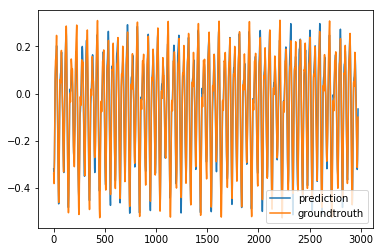

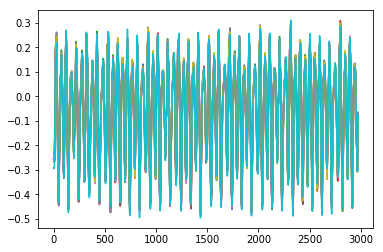

Ensemble error is 83.84019549936954% of best single ESN error


In [133]:
plt.plot(finalPrediction, label="prediction")
plt.plot(outputDataValidation, label="groundtrouth")
plt.legend()
plt.show()

for dat in singlePredictions:
    plt.plot(dat)
plt.show()

#calculate error value
judgeMSE = np.mean((finalPrediction - outputDataValidation)**2)
#print(judgeMSE)

#calculate best performing single error
singlePredictions = np.array(singlePredictions)
singleMSEs = []
for i in range(len(singlePredictions)):
    singleMSEs.append(np.mean((outputDataValidation - singlePredictions[i])**2))
singleMSEs = np.array(singleMSEs)

bestSingleMSE = np.min(singleMSEs)
    
#print(bestSingleMSE)

print("Ensemble error is {0}% of best single ESN error".format(100.0/bestSingleMSE*judgeMSE))

In [ ]:
trainErrors = []
trainPredictions = []

#TODO: get value for transientTimeValue
transientTimeValue = 100

ensembleSize = 10
ensemble = []

#train ensemble
for _ in range(ensembleSize):
    esn = PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    ensemble.append(esn)
    error = esn.fit(inputDataTraining, outputDataTraining)
    esn.resetState()
    prediction = esn.predict(inputDataTraining)
    trainPredictions.append(prediction)
    trainErrors.append(error)


judgeESNTrainData = np.array(trainPredictions)#.reshape(-1, len(trainPredictions))
judgeESNTrainData = np.vstack((inputDataTraining.reshape((1, -1, 1)), judgeESNTrainData))
judgeESNTrainData = judgeESNTrainData.T[0, transientTimeValue:]

trainErrors = np.array(trainErrors)  
weights = trainErrors / np.sum(trainErrors) * len(ensemble)

judge = PredictionESN(n_input=1 + ensembleSize, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
judge.fit(judgeESNTrainData, outputDataTraining[transientTimeValue:, ], transientTime="Auto")

In [20]:
#get predictions
predictions = []
for esn in ensemble:
    prediction = esn.predict(inputDataValidation)
    predictions.append(prediction)

judgeESNInputData = np.array(predictions)
judgeESNInputData = np.vstack((inputDataValidation.reshape(1, -1, 1), judgeESNInputData))
judgeESNInputData = judgeESNInputData.T[0]

finalPrediction = judge.predict(judgeESNInputData)

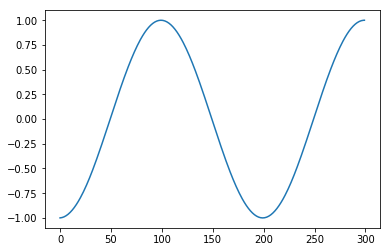

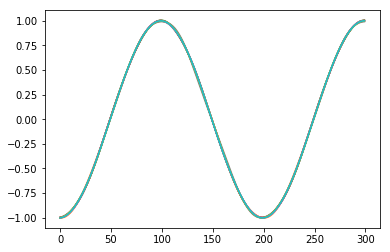

In [21]:
plt.plot(finalPrediction)
plt.show()

for a in predictions:
    plt.plot(a)
plt.show()

In [9]:
judge._WOut

array([[-3.07110645e+00,  3.67497970e+00,  1.75495856e-01,
         6.52550501e-03, -7.40927348e-02, -1.00456961e-01,
        -9.49669496e-02, -7.15220737e-02, -3.82776906e-02,
         2.84275918e-04,  4.19096462e-02,  8.55946417e-02,
         6.32259295e-01, -3.34718571e-01, -6.36662989e-01,
        -1.30688493e+00,  8.39671516e-01, -3.16391040e-01,
         4.13176362e-01, -1.50605515e+00, -6.29995320e-01,
         6.84388353e-01, -4.86265719e-03,  1.64239863e+00,
        -7.84940454e-01, -2.38901397e-01, -5.95866106e-01,
        -7.73475798e-01,  6.98809934e-01,  2.34469289e+00,
         4.39528888e-02,  3.03168730e-01,  1.16971204e+00,
        -1.32212480e+00,  6.39020433e-01,  2.29544087e+00,
         1.82479845e-01, -4.67998502e-02, -2.18350753e+00,
         3.92424128e-01, -1.08341352e+00,  3.27581510e-01,
        -1.01137568e+00, -6.73759285e-01, -9.98251607e-01,
        -5.02757951e-01,  2.47259528e-02,  2.46858099e-01,
        -7.14414024e-02,  1.33537394e-01,  9.86361414e-0